In [1]:
from sklearn.datasets import make_circles
from sklearn.datasets import load_digits
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider

import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
import numpy as np
import pandas as pd

from itertools import product

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

## Question 4) Kernel Perceptrons
Previously, you've used perceptrons for binary classification problems. We've already seen in this assignment that we can apply kernels to PCA, but the potential of kernels is limitless. In this question, we'll kernalize perceptrons to express richer decision boundaries than the simple decision boundaries you've seen thus far.

### Question 4a)
Run the following code to visualize our dataset, and answer the following questions.
* **Is the data linearly separable?** No, lol.

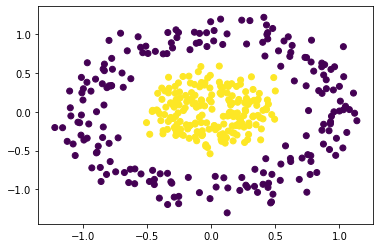

In [2]:
X, y = make_circles(n_samples=400, factor=.3, noise=.12)
plt.scatter(X[:,0], X[:,1], c=y)

Let's try to fit a perceptron to this data. Fill in the following code to fit a Perceptron classifier `clf` to X and y. If you're struggling, check out your notes from the Perceptron unit. Here are some other helpful resources:
- [sklearn perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html)
- [CS188 perceptron slides](https://inst.eecs.berkeley.edu/~cs188/sp12/slides/cs188%20lecture%2021%20--%20perceptron%202PP.pdf)

'Perceptron accuracy on original data: 0.5'

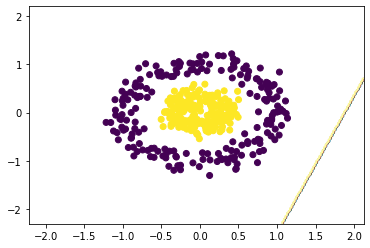

In [3]:
# START TODO
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X, y)
# END TODO

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.scatter(X[:,0], X[:,1], c=y)
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
"Perceptron accuracy on original data: " + str(clf.score(X,y))

### Question 4b)
Now let's try lifting the data to a higher dimensional feature space so that we can classify this with a Perceptron better. Let's apply the following feature map:
\begin{equation*}
\phi (x) = [x_1, x_2, x_1^2 + x_2^2]
\end{equation*}
Fill in the following code to create a data matrix `phi` that contains our augmented data, and visualize phi.   
**Hints:**  
* Check out np.column_stack https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html#numpy.column_stack 

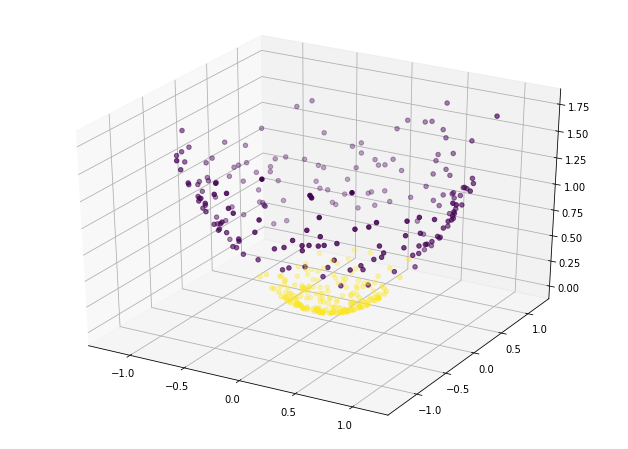

In [4]:
# START TODO
phi = np.column_stack([X[:,0], X[:,1], X[:,0]**2 + X[:,1]**2])
# END TODO

fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(phi[:,0],phi[:,1],phi[:,2], c=y)



Answer the following questions.
* **Is the data separable now?** The richer feature space is expressive enough to separate the points with a hyperplane, unlike the old space.

Now let's try using the perceptron on this augmented dataset, and see how it performs. This is a little janky, but you can use the sliders to control the view of the 3d plot.

In [5]:
def viz_perceptron(x_rotate, y_rotate):
    # START TODO
    
    clf = Perceptron(tol=1e-3, random_state=0)
    clf.fit(phi, y)
    
    # START TODO
    
    print ("Perceptron accuracy on lifted data: " + str(clf.score(phi, y)))

    z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

    tmp = np.linspace(-5,5,30)
    x_surf,y_surf = np.meshgrid(tmp,tmp)

    fig = plt.figure(figsize=(11,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(phi[:,0],phi[:,1],phi[:,2], c=y)
    ax.plot_surface(x_surf, y_surf, z(x_surf,y_surf))
    ax.view_init(y_rotate, x_rotate)

    plt.show()
    
x_widget = IntSlider(min=-100, max=100)
y_widget = IntSlider(min=-100, max=100)
interact(viz_perceptron,x_rotate=x_widget,y_rotate=y_widget)


interactive(children=(IntSlider(value=0, description='x_rotate', min=-100), IntSlider(value=0, description='y_…

<function __main__.viz_perceptron(x_rotate, y_rotate)>

We can now see that lifting our features can be very advantageous to making a perceptron work. At this point this should scream kernels to you. Whenever we want to work in high dimensional spaces, a kernel would certainly help. So how do we kernelize the perceptron?

### Question 4c)
In order to kernelize perceptrons, we need to think about about how perceptrons actually work in the first place. For a refresher, let's fill in the following code for a homemade `MyPerceptron` class that trains on training data for `num_iterations`. If you're stuck, check the resources above, and the wikipedia page on the [perceptron](https://en.wikipedia.org/wiki/Perceptron#Learning_algorithm)! It's quite helpful as well :).

In [6]:
for i in range(len(y)):
    if y[i] == 0:

        y[i] = -1

        
class MyPerceptron:
    def __init__(self, num_iterations = 5):
        self.num_iterations = num_iterations
        
    def predict(self, x):
        # START TODO
        return np.sign(self.w.T@x)
        # END TODO
    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iterations):
            for x_i, y_i in zip(X, y):
                # START TODO
                y_hat = self.predict(x_i)
                if y_hat != y_i:
                    self.w = self.w + y_i * x_i
                # END TODO
    def score(self, X, y):
        # START TODO
        correct = 0
        for x_i, y_i in zip(X, y):
            y_hat = self.predict(x_i)
            correct += 1 if y_hat == y_i else 0
        # END TODO
        accuracy = correct / X.shape[0]
        return accuracy

Confirm that this works by testing classification accuracy on the original dataset, it should be around 50%.

In [7]:
clf = MyPerceptron(10)
X_with_ones = np.column_stack([np.ones(X.shape[0]), X[:,0],X[:,1]])
clf.fit(X_with_ones, y)
print("Accuracy of MyPerceptron: ", clf.score(X_with_ones,y))


Accuracy of MyPerceptron:  0.5125


Let's look at where the kernel perceptron algorithm comes from.  
*Note: for more information visit the wikipedia page as well: https://en.wikipedia.org/wiki/Kernel_perceptron*
* **To proceed with kernalizing this, let's first write out our update step.** \begin{equation} w + y_i * x_i \end{equation}
* **Notice that w is a linear combination of our data points. w starts at zero, and only changes by getting some portion of all our data points.** (If this doesn't make sense to you read the notes once more).
* **This means that we can write our w as follows.** \begin{equation} w = \sum_{i}^{n} \alpha_i y_i \vec{x_i}  \end{equation}
* **Now let's write our actual prediction formula for a given datapoint x.**
\begin{equation} sign(w^T x) = sign((\sum_{i}^{n} \alpha_i y_i \vec x_i)^T \vec x) = sign(\sum_{i}^{n} \alpha_i y_i (\vec x_i \cdot \vec x))\end{equation}
* **Notice now that we can see an inner product in our formula for the prediction. We can replace that with a kernel function.**
\begin{equation} sign(w^T x) = sign((\sum_{i}^{n} \alpha_i y_i \vec x_i)^T \vec x) = sign(\sum_{i}^{n} \alpha_i y_i k(\vec x_i, \vec x))\end{equation}

* **You can see how the kernel function has worked its way into the prediction function. To perform our update step, we are no longer working with the weights `w`. We are now working with the weights $\alpha$ instead, so we can perform this update step:** \begin{equation} a = a + 1 \end{equation} if a point is misclassified.

Now that we understand the update step and predict formula, let's implement this regression by filling  out `MyKernelPerceptron`.

In [8]:
class MyKernelPerceptron:
    def __init__(self, kernel_function, num_iterations = 5):
        self.num_iterations = num_iterations
        self.k = kernel_function
    def predict(self, y, X, x):
        # START TODO
        s = 0
        for i in range(X.shape[0]):

            s += self.a[i] * y[i] * self.k(X[i], x)
        return np.sign(s)
        # END TODO
    def fit(self, X, y):
        self.a = np.zeros(X.shape[0])
        for iteration in range(self.num_iterations):
            
            for i, x_i, y_i in zip(range(X.shape[0]),X, y):
                y_hat = self.predict(y, X, x_i)
                if y_hat != y_i:
                    # START TODO
                    self.a[i] = self.a[i] + 1
                    # END TODO
    def score(self, X, y):
        # START TODO
        correct = 0
        for x_i, y_i in zip(X, y):
            y_hat = self.predict(y, X, x_i)
            
            if y_hat == y_i:
                correct += 1

        # END TODO
        accuracy = correct / X.shape[0]
        return accuracy

Now complete the code for the `rbf_kernel` implementation with a $\gamma$ = 3.

In [9]:
def linear_kernel(x, z):
    return x.T@z
def rbf_kernel(x,z):
    # START TODO
    gamma = 3
    return np.exp(-gamma*np.linalg.norm(x - z)**2)
    # END TODO

clf = MyKernelPerceptron(rbf_kernel, 3)

clf.fit(X_with_ones, y)
print("Accuracy of MyKernelPerceptron with rbf kernel", clf.score(X_with_ones,y))

clf = MyKernelPerceptron(linear_kernel, 3)

clf.fit(X_with_ones, y)
print("Accuracy of MyKernelPerceptron with linear kernel", clf.score(X_with_ones,y))

Accuracy of MyKernelPerceptron with rbf kernel 0.995
Accuracy of MyKernelPerceptron with linear kernel 0.505


Answer the following questions.  
* **Which perceptron performed better?** The kernel perceptron performed much better with an rbf kernel.
* **When would it be preferable to use MyKernelPerceptron on the original data over MyPerceptron on lifted data?** When d > n, or the number of features we are projecting to is higher than the number of points. In this case, d=3 is rich enough and quite fast to compute.